In [1]:
import pandas as pd
import numpy as np
import requests
import shelve
import os
from datetime import datetime
import matplotlib.pyplot as plt
import re
import ipywidgets as widgets
from IPython.display import display, clear_output
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [2]:
user="lholguin"
#user in personal pc <- "asus"

In [5]:
class NDCATCAnalyzer:

    def __init__(self, year, base_path=None):

        self.year = year
        if base_path is None:
            #Lookup the user's base path
            self.base_path = rf"c:\Users\{user}\OneDrive - purdue.edu\VS code\Data"
        else:
            self.base_path = base_path
            
        self.df_cleaned = None
        self.df_merged = None
        self.atc_mapping = None
        self.df_faf = None
        
    def clean_sdud_data(self):
        csv_file = os.path.join(self.base_path, f"SDUD\\SDUD{self.year}.csv")
        print(f"Reading CSV file: {csv_file}")
        
        # Read with NDC as string to preserve leading zeros
        df = pd.read_csv(csv_file, dtype={'NDC': 'object'})
        
        print(f"Total rows in {self.year} before filtering: {len(df)}")
        
        # Remove NA values
        df_filtered = df.dropna(subset=['Units Reimbursed', 'Number of Prescriptions'])
        print(f"Rows after removing NA: {len(df_filtered)}")
        
        # Filter out State='XX'
        df_filtered = df_filtered[df_filtered['State'] != 'XX']
        print(f"Rows after filtering State='XX': {len(df_filtered)}")
        print(f"Unique NDCs: {df_filtered['NDC'].nunique()}")
        
        self.df_cleaned = df_filtered
        return self.df_cleaned
    
    def generate_ndc_txt(self, output_filename=None):
        """Step 2: Generate text file with unique NDC values."""
        if self.df_cleaned is None:
            raise ValueError("Must run clean_sdud_data() first")
            
        if output_filename is None:
            output_filename = f"NDCf_{self.year}.txt"
        
        output_path = os.path.join(self.base_path, f"ATC\\text_files\\Text_files_notgood\\{output_filename}")
        
        ndc_values = self.df_cleaned['NDC']
        with open(output_path, 'w') as f:
            for ndc in ndc_values:
                f.write(str(ndc) + '\n')
        
        print(f"Saved {len(ndc_values)} NDC values to {output_path}")
        print(f"Unique NDC values: {ndc_values.nunique()}")
        return output_path
    
    def analyze_atc4_mapping(self):
        """Step 3: Analyze ATC4 mapping results and identify missing NDCs."""
        atc4_path = os.path.join(self.base_path, f"ATC\\ATC4_classes\\Classes_notgood\\NDCf_{self.year}_ATC4_classes.csv")
        
        # Read ATC4 mapping
        df_atc4 = pd.read_csv(atc4_path, dtype={'NDC': 'object'})
        df_atc4['NDC'] = df_atc4['NDC'].str.zfill(11)
        
        print(f"Unique ATC4 Classes: {df_atc4['ATC4 Class'].nunique()}")
        print(f"Unique NDCs in ATC4 mapping: {df_atc4['NDC'].nunique()}")
        
        # Merge with cleaned data
        merged_df = pd.merge(self.df_cleaned, df_atc4, on='NDC', how='left')
        
        # Find missing NDCs
        missing_atc = merged_df[merged_df['ATC4 Class'].isna()]
        missing_ndcs = missing_atc['NDC'].unique()
        
        print(f"NDCs without ATC4 Class: {len(missing_ndcs)}")
        print(f"NDCs with ATC4 Class: {merged_df[merged_df['ATC4 Class'].notna()]['NDC'].nunique()}")
        
        # Save missing NDCs
        missing_file = os.path.join(self.base_path, f"ATC\\text_files\\Text_files_notgood\\NDC_missing_{self.year}.txt")
        with open(missing_file, 'w') as f:
            for ndc in missing_ndcs:
                f.write(str(ndc) + '\n')
        print(f"Saved missing NDCs to {missing_file}")
        
        self.atc_mapping = merged_df
        return missing_ndcs
    
    def analyze_atc5_missing(self):
        """Step 3b: Analyze ATC5 results for missing NDCs."""
        miss_path = os.path.join(self.base_path, f"ATC\\NDC_missing_ATC5\\NDC_missing_{self.year}_ATC5_classes.csv")
        
        # Check if the file exists first
        if not os.path.exists(miss_path):
            print(f"ATC5 missing file not found: {miss_path}")
            print("This file would be generated by running ATC5 classification on the missing NDCs.")
            return None
            
        df_miss = pd.read_csv(miss_path)
        
        rxcui_no = df_miss[df_miss['ATC5 Class'] == 'No RxCUI Found'].shape[0]
        atc_no = df_miss[df_miss['ATC5 Class'] == 'No ATC Mapping Found'].shape[0]
        
        print(f"NDCs with no RxCUI: {rxcui_no}")
        print(f"NDCs with no ATC mapping: {atc_no}")
        
        return df_miss
    
    def add_atc_names(self, cache_path=None):
        """Step 4-5: Add ATC class names and merge with cleaned data, including missing NDCs with ATC5."""
        if cache_path is None:
            cache_path = os.path.join(self.base_path, "ATC\\cache_files\\atc_names_cache")
        
        atc4_path = os.path.join(self.base_path, f"ATC\\ATC4_classes\\Classes_notgood\\NDCf_{self.year}_ATC4_classes.csv")
        output_path = os.path.join(self.base_path, f"ATC\\ATC4_names\\ATC4_names{self.year}.csv")
        
        # Use existing function logic for ATC4 mappings
        df_names = self._fetch_atc_names(atc4_path, cache_path)
        df_names.to_csv(output_path, index=False)
        
        # Add missing NDCs with ATC5 classifications (if the file exists)
        atc5_missing_path = os.path.join(self.base_path, f"ATC\\NDC_missing_ATC5\\NDC_missing_{self.year}_ATC5_classes.csv")
        
        if os.path.exists(atc5_missing_path):
            print(f"Found ATC5 missing file: {atc5_missing_path}")
            try:
                df_atc5_missing = pd.read_csv(atc5_missing_path, dtype={'NDC': 'object'})
                
                # Create ATC2 and ATC3 from ATC5 for missing NDCs that have valid ATC5
                df_atc5_missing = df_atc5_missing.copy()
                df_atc5_missing['ATC4 Class'] = df_atc5_missing['ATC5 Class']
                
                # Only process NDCs that have valid ATC5 mappings (not "No RxCUI Found" or "No ATC Mapping Found")
                valid_atc5 = df_atc5_missing[
                    (~df_atc5_missing['ATC5 Class'].isin(['No RxCUI Found', 'No ATC Mapping Found'])) &
                    (df_atc5_missing['ATC5 Class'].notna()) &
                    (df_atc5_missing['ATC5 Class'] != '')
                ].copy()
                
                if len(valid_atc5) > 0:
                    # Create ATC levels from ATC5
                    valid_atc5['ATC3 Class'] = valid_atc5['ATC5 Class'].str[:4]
                    valid_atc5['ATC2 Class'] = valid_atc5['ATC5 Class'].str[:3]
                    
                    # Add empty name columns (these will be filled by fetching names)
                    valid_atc5['ATC4_Name'] = ''
                    valid_atc5['ATC3_Name'] = ''
                    valid_atc5['ATC2_Name'] = ''
                    
                    # Reorder columns to match df_names structure
                    valid_atc5 = valid_atc5[['NDC', 'ATC4 Class', 'ATC4_Name', 'ATC3 Class', 'ATC3_Name', 'ATC2 Class', 'ATC2_Name']]
                    
                    # Combine with existing ATC4 mappings
                    df_names_combined = pd.concat([df_names, valid_atc5], ignore_index=True)
                    
                    print(f"Added {len(valid_atc5)} NDCs with valid ATC5 classifications")
                else:
                    df_names_combined = df_names
                    print("No valid ATC5 classifications found to add")
                    
            except Exception as e:
                print(f"Error reading ATC5 missing file: {e}")
                df_names_combined = df_names
        else:
            print(f"ATC5 missing file not found: {atc5_missing_path}")
            print("Proceeding with only ATC4 mappings. To get more coverage:")
            print("1. Use the missing NDCs file to run ATC5 classification")
            print("2. Save results as NDC_missing_{year}_ATC5_classes.csv")
            df_names_combined = df_names
        
        # Merge with cleaned data
        self.df_merged = pd.merge(self.df_cleaned, df_names_combined, on='NDC', how='left')
        
        # Scale units
        self.df_merged['Units Reimbursed'] = self.df_merged['Units Reimbursed'] / 1e9
        self.df_merged['Number of Prescriptions'] = self.df_merged['Number of Prescriptions'] / 1e6
        
        # Report final statistics - Updated mapping coverage calculation
        total_ndcs_cleaned = self.df_cleaned['NDC'].nunique()  # Total unique NDCs in cleaned dataset
        mapped_ndcs = self.df_merged[self.df_merged['ATC4 Class'].notna()]['NDC'].nunique()  # NDCs with ATC4 class
        
        print(f"\nFinal mapping statistics:")
        print(f"Total unique NDCs in cleaned dataset: {total_ndcs_cleaned}")
        print(f"NDCs with ATC4 classification: {mapped_ndcs}")
        print(f"Mapping coverage: {mapped_ndcs/total_ndcs_cleaned*100:.1f}%")
        
        return self.df_merged
    
    def _fetch_atc_names(self, input_file, cache_path):
        """Helper method to fetch ATC names (Step 4 logic)."""
        print(f"Using cache: {cache_path}")
        
        # Read CSV
        print(f"Reading {input_file}...")
        df = pd.read_csv(input_file, dtype={'NDC': 'object'})
        
        print(f"Total rows: {len(df)}")
        print(f"Original columns: {df.columns.tolist()}")
        
        # Create ATC3 and ATC2 columns from ATC4
        print("\nCreating ATC3 and ATC2 columns from ATC4...")
        df['ATC3 Class'] = df['ATC4 Class'].str[:4]
        df['ATC2 Class'] = df['ATC4 Class'].str[:3]
        
        print(df[['ATC4 Class', 'ATC3 Class', 'ATC2 Class']].head(10))
        
        # Add name columns
        df['ATC4_Name'] = ''
        df['ATC3_Name'] = ''
        df['ATC2_Name'] = ''
        
        # Get unique codes for each level
        unique_atc4 = df['ATC4 Class'].dropna().unique()
        unique_atc3 = df['ATC3 Class'].dropna().unique()
        unique_atc2 = df['ATC2 Class'].dropna().unique()
        
        # Filter out invalid codes
        unique_atc4 = [c for c in unique_atc4 if c not in ['No ATC Mapping Found', 'No RxCUI Found', '']]
        unique_atc3 = [c for c in unique_atc3 if c not in ['No ATC Mapping Found', 'No RxCUI Found', '', 'No ', 'No']]
        unique_atc2 = [c for c in unique_atc2 if c not in ['No ATC Mapping Found', 'No RxCUI Found', '', 'No ', 'No']]
        
        print(f"\nUnique codes to fetch:")
        print(f"  ATC4: {len(unique_atc4)}")
        print(f"  ATC3: {len(unique_atc3)}")
        print(f"  ATC2: {len(unique_atc2)}")
        
        total_codes = len(unique_atc4) + len(unique_atc3) + len(unique_atc2)
        
        # Build mappings
        atc4_names = {}
        atc3_names = {}
        atc2_names = {}
        
        with shelve.open(cache_path) as cache:
            start_time = datetime.now()
            processed = 0
            
            # Process ATC4 (without progress printing)
            for code in unique_atc4:
                processed += 1
                atc4_names[code] = self._get_atc_name(code, cache)
            
            # Process ATC3 (without progress printing)
            for code in unique_atc3:
                processed += 1
                atc3_names[code] = self._get_atc_name(code, cache)
            
            # Process ATC2 (without progress printing)
            for code in unique_atc2:
                processed += 1
                atc2_names[code] = self._get_atc_name(code, cache)
            
            print(f"\nTotal processing time: {(datetime.now() - start_time).total_seconds()/60:.1f} minutes")
        
        # Apply mappings to dataframe
        print("\nApplying names to dataframe...")
        df['ATC4_Name'] = df['ATC4 Class'].map(atc4_names).fillna('')
        df['ATC3_Name'] = df['ATC3 Class'].map(atc3_names).fillna('')
        df['ATC2_Name'] = df['ATC2 Class'].map(atc2_names).fillna('')
        
        # Reorder columns to group code and name together
        column_order = ['NDC', 
                        'ATC4 Class', 'ATC4_Name',
                        'ATC3 Class', 'ATC3_Name',
                        'ATC2 Class', 'ATC2_Name']
        df = df[column_order]
        
        print(f"\nComplete! Total rows: {len(df)}")
        print("\nSample output:")
        print(df[['ATC4 Class', 'ATC4_Name', 'ATC3 Class', 'ATC3_Name', 'ATC2 Class', 'ATC2_Name']].head(10))
        
        return df
    
    def _get_atc_name(self, atc_code, cache):
        """Get ATC class name from code, using cache."""
        cache_key = f"atc_name:{atc_code}"
        if cache_key in cache:
            return cache[cache_key]
        
        try:
            url = f"https://rxnav.nlm.nih.gov/REST/rxclass/class/byId.json?classId={atc_code}"
            response = requests.get(url)
            response.raise_for_status()
            data = response.json()
            
            # Get class name
            if 'rxclassMinConceptList' in data and 'rxclassMinConcept' in data['rxclassMinConceptList']:
                concepts = data['rxclassMinConceptList']['rxclassMinConcept']
                if concepts:
                    name = concepts[0].get('className', '')
                    cache[cache_key] = name
                    return name
            
            cache[cache_key] = ''
            return ''
            
        except Exception as e:
            print(f"Error retrieving name for {atc_code}: {e}")
            cache[cache_key] = ''
            return ''
    
    def export_merged_data(self, output_filename=None):
        """Export the merged dataframe to CSV."""
        if self.df_merged is None:
            raise ValueError("Must run add_atc_names() first to create merged dataframe")
            
        if output_filename is None:
            output_filename = f"merged_data_{self.year}.csv"

        output_path = os.path.join(self.base_path, f"ATC\\merged_data\\mapping_notgood\\{output_filename}")

        # Create directory if it doesn't exist
        os.makedirs(os.path.dirname(output_path), exist_ok=True)

        self.df_merged.to_csv(output_path, index=False)
        print(f"Exported merged data to: {output_path}")
        print(f"Total rows exported: {len(self.df_merged)}")
        return output_path
    
    def remove_duplicates(self, subset_columns=None):
        """Remove duplicate rows based on Units Reimbursed, Number of Prescriptions, State, and Quarter."""
        if self.df_merged is None:
            raise ValueError("Must run add_atc_names() first to create merged dataframe")
        
        if subset_columns is None:
            subset_columns = ['NDC','Units Reimbursed', 'Number of Prescriptions', 'State', 'Quarter','Utilization Type']
        
        print(f"\nRemoving duplicates based on: {subset_columns}")
        print(f"Rows before duplicate removal: {len(self.df_merged)}")
        
        # Count duplicates before removal
        duplicates_count = len(self.df_merged) - len(self.df_merged.drop_duplicates(subset=subset_columns))
        
        # Remove duplicates
        self.df_merged = self.df_merged.drop_duplicates(subset=subset_columns, keep='first')
        
        print(f"Rows after duplicate removal: {len(self.df_merged)}")
        print(f"Duplicates removed: {duplicates_count}")
        
        return self.df_merged


In [6]:
# Create analyzer instance
analyzer = NDCATCAnalyzer(year=2023)

# Run the complete workflow
analyzer.clean_sdud_data()
analyzer.generate_ndc_txt()
analyzer.analyze_atc4_mapping()

# This will now work fully - it fetches ATC names and merges with cleaned data
df_merged = analyzer.add_atc_names()

# Remove duplicates and export
df_cleaned_duplicates = analyzer.remove_duplicates()
analyzer.export_merged_data()

Reading CSV file: c:\Users\lholguin\OneDrive - purdue.edu\VS code\Data\SDUD\SDUD2023.csv
Total rows in 2023 before filtering: 5277298
Rows after removing NA: 2651527
Rows after filtering State='XX': 2413521
Unique NDCs: 34439
Saved 2413521 NDC values to c:\Users\lholguin\OneDrive - purdue.edu\VS code\Data\ATC\text_files\Text_files_notgood\NDCf_2023.txt
Unique NDC values: 34439
Unique ATC4 Classes: 611
Unique NDCs in ATC4 mapping: 32499
NDCs without ATC4 Class: 1940
NDCs with ATC4 Class: 32499
Saved missing NDCs to c:\Users\lholguin\OneDrive - purdue.edu\VS code\Data\ATC\text_files\Text_files_notgood\NDC_missing_2023.txt
Using cache: c:\Users\lholguin\OneDrive - purdue.edu\VS code\Data\ATC\cache_files\atc_names_cache
Reading c:\Users\lholguin\OneDrive - purdue.edu\VS code\Data\ATC\ATC4_classes\Classes_notgood\NDCf_2023_ATC4_classes.csv...
Total rows: 62105
Original columns: ['NDC', 'ATC4 Class']

Creating ATC3 and ATC2 columns from ATC4...
  ATC4 Class ATC3 Class ATC2 Class
0      D06BX

'c:\\Users\\lholguin\\OneDrive - purdue.edu\\VS code\\Data\\ATC\\merged_data\\mapping_notgood\\merged_data_2023.csv'

In [14]:
# Check total sums
total_units = analyzer.df_merged['Units Reimbursed'].sum()
total_prescriptions = analyzer.df_merged['Number of Prescriptions'].sum()

print(f"\nTotal Statistics:")
print(f"Total Units Reimbursed: {total_units:.4f} Billion")
print(f"Total Number of Prescriptions: {total_prescriptions:.4f} Million")
print(f"Total rows in dataset: {len(analyzer.df_merged):,}")


Total Statistics:
Total Units Reimbursed: 46.3360 Billion
Total Number of Prescriptions: 729.4256 Million
Total rows in dataset: 2,362,630


Analyzing state: IN
Total records for IN: 66,501

Top 5 ATC Classes in IN:
1. N06AX: 0.89 million prescriptions
2. N06BA: 0.77 million prescriptions
3. N06AB: 0.73 million prescriptions
4. R03CC: 0.53 million prescriptions
5. A06AH: 0.42 million prescriptions


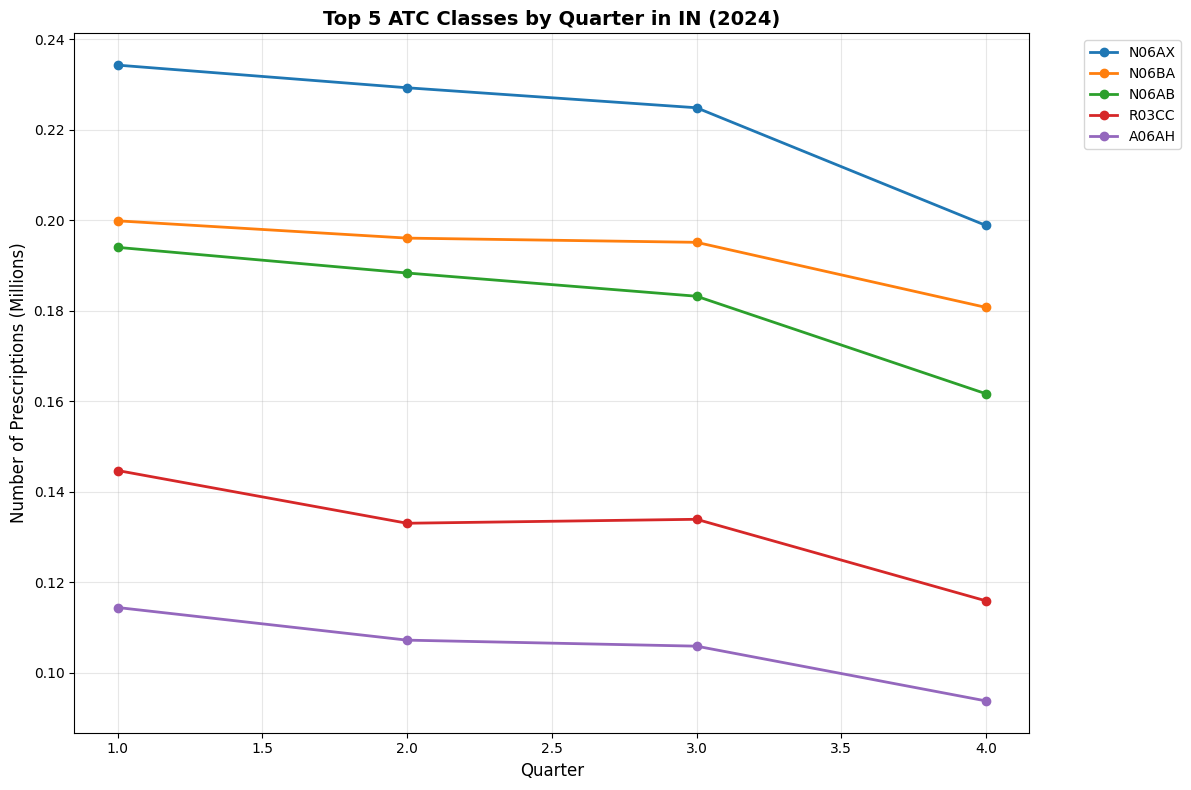


Summary table for IN:
ATC4 Class  A06AH  N06AB  N06AX  N06BA  R03CC
Quarter                                      
1            0.11   0.19   0.23   0.20   0.14
2            0.11   0.19   0.23   0.20   0.13
3            0.11   0.18   0.22   0.20   0.13
4            0.09   0.16   0.20   0.18   0.12


In [15]:
# Plot Year vs Top 5 ATC Classes for a Single State
if 'analyzer' in globals() and hasattr(analyzer, 'df_merged') and analyzer.df_merged is not None:
    # Select state to analyze (change this to any state you want)
    target_state = 'IN'  # Indiana - change to any state code
    
    # Filter data for the target state
    state_data = analyzer.df_merged[analyzer.df_merged['State'] == target_state].copy()
    
    if len(state_data) > 0:
        print(f"Analyzing state: {target_state}")
        print(f"Total records for {target_state}: {len(state_data):,}")
        
        # Group by Quarter (year) and ATC4 Class, sum prescriptions
        quarterly_atc = state_data.groupby(['Quarter', 'ATC4 Class']).agg({
            'Number of Prescriptions': 'sum',
            'Units Reimbursed': 'sum'
        }).reset_index()
        
        # Find top 5 ATC classes by total prescriptions across all quarters
        top_atc_classes = quarterly_atc.groupby('ATC4 Class')['Number of Prescriptions'].sum().sort_values(ascending=False).head(5)
        top_5_classes = top_atc_classes.index.tolist()
        
        print(f"\nTop 5 ATC Classes in {target_state}:")
        for i, atc_class in enumerate(top_5_classes, 1):
            total_prescriptions = top_atc_classes[atc_class]
            print(f"{i}. {atc_class}: {total_prescriptions:.2f} million prescriptions")
        
        # Filter data for top 5 classes only
        top_5_data = quarterly_atc[quarterly_atc['ATC4 Class'].isin(top_5_classes)].copy()
        
        # Create the plot
        plt.figure(figsize=(12, 8))
        
        # Plot each ATC class as a separate line
        for atc_class in top_5_classes:
            class_data = top_5_data[top_5_data['ATC4 Class'] == atc_class]
            plt.plot(class_data['Quarter'], class_data['Number of Prescriptions'], 
                    marker='o', linewidth=2, label=atc_class)
        
        plt.title(f'Top 5 ATC Classes by Quarter in {target_state} ({analyzer.year})', fontsize=14, fontweight='bold')
        plt.xlabel('Quarter', fontsize=12)
        plt.ylabel('Number of Prescriptions (Millions)', fontsize=12)
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
        
        # Show summary table
        print(f"\nSummary table for {target_state}:")
        summary_pivot = top_5_data.pivot(index='Quarter', columns='ATC4 Class', values='Number of Prescriptions').fillna(0)
        print(summary_pivot.round(2))
        
    else:
        print(f"No data found for state: {target_state}")
        print(f"Available states: {sorted(analyzer.df_merged['State'].unique())}")
        
else:
    print("Please run the NDC-ATC workflow first!")

In [16]:
# Interactive Plot with Filters using Plotly
if 'analyzer' in globals() and hasattr(analyzer, 'df_merged') and analyzer.df_merged is not None:
    
    # Get unique values for filters
    states = ['All States']+sorted(analyzer.df_merged['State'].unique())
    years = sorted(analyzer.df_merged['Year'].unique()) if 'Year' in analyzer.df_merged.columns else [analyzer.year]
    quarters = ['All'] + sorted([str(q) for q in analyzer.df_merged['Quarter'].unique()])
    
    # Create dropdown widgets
    state_dropdown = widgets.Dropdown(
        options=states,
        value=states[0],
        description='State:',
        disabled=False,
    )
    
    year_dropdown = widgets.Dropdown(
        options=years,
        value=years[0],
        description='Year:',
        disabled=False,
    )
    
    quarter_dropdown = widgets.Dropdown(
        options=quarters,
        value='All',
        description='Quarter:',
        disabled=False,
    )
    
    top_n_slider = widgets.IntSlider(
        value=10,
        min=5,
        max=20,
        step=5,
        description='Top N:',
        disabled=False,
    )
    
    # Create output widget
    output = widgets.Output()
    
    def update_plot(change=None):
        with output:
            clear_output(wait=True)
            
            state = state_dropdown.value
            year = year_dropdown.value
            quarter = quarter_dropdown.value
            top_n = top_n_slider.value
            #Filtering
            if state=='All States':
                filtered_data=analyzer.df_merged.copy()
            else:
                filtered_data = analyzer.df_merged[analyzer.df_merged['State'] == state].copy()

            # Filter data by state and year
            filtered_data = analyzer.df_merged[
                analyzer.df_merged['State'] == state
            ].copy()
            
            if 'Year' in analyzer.df_merged.columns:
                filtered_data = filtered_data[filtered_data['Year'] == year]
            
            # Filter by quarter if not 'All'
            if quarter != 'All':
                filtered_data = filtered_data[filtered_data['Quarter'] == int(quarter)]
            
            quarter_text = f"Q{quarter}" if quarter != 'All' else "All Quarters"
            
            if len(filtered_data) == 0:
                print(f"No data available for State: {state}, Year: {year}, Quarter: {quarter_text}")
                return
            
            # Group by ATC3 Class and sum metrics
            atc3_summary = filtered_data.groupby(['ATC3 Class', 'ATC3_Name']).agg({
                'Units Reimbursed': 'sum',
                'Number of Prescriptions': 'sum'
            }).reset_index()
            
            # Create labels combining code and name
            atc3_summary['Label'] = atc3_summary['ATC3 Class'] + ': ' + atc3_summary['ATC3_Name']
            
            # Get top N for each metric
            top_units = atc3_summary.nlargest(top_n, 'Units Reimbursed').sort_values('Units Reimbursed', ascending=True)
            top_prescriptions = atc3_summary.nlargest(top_n, 'Number of Prescriptions').sort_values('Number of Prescriptions', ascending=True)
            
            # Create subplots
            fig = make_subplots(
                rows=2, cols=1,
                subplot_titles=(
                    f'Top {top_n} ATC3 Classes by Units Reimbursed<br>{state} - {year} - {quarter_text}',
                    f'Top {top_n} ATC3 Classes by Number of Prescriptions<br>{state} - {year} - {quarter_text}'
                ),
                vertical_spacing=0.15
            )
            
            # Add first bar chart (Units Reimbursed)
            fig.add_trace(
                go.Bar(
                    y=top_units['Label'],
                    x=top_units['Units Reimbursed'],
                    orientation='h',
                    marker=dict(
                        color=top_units['Units Reimbursed'],
                        colorscale='YlGnBu',
                        showscale=False
                    ),
                    text=[f'{val:.2f}B' for val in top_units['Units Reimbursed']],
                    textposition='outside',
                    hovertemplate='<b>%{y}</b><br>Units: %{x:.2f}B<extra></extra>'
                ),
                row=1, col=1
            )
            
            # Add second bar chart (Number of Prescriptions)
            fig.add_trace(
                go.Bar(
                    y=top_prescriptions['Label'],
                    x=top_prescriptions['Number of Prescriptions'],
                    orientation='h',
                    marker=dict(
                        color=top_prescriptions['Number of Prescriptions'],
                        colorscale='OrRd',
                        showscale=False
                    ),
                    text=[f'{val:.2f}M' for val in top_prescriptions['Number of Prescriptions']],
                    textposition='outside',
                    hovertemplate='<b>%{y}</b><br>Prescriptions: %{x:.2f}M<extra></extra>'
                ),
                row=2, col=1
            )
            
            # Update layout
            fig.update_xaxes(title_text='Units Reimbursed (Billions)', row=1, col=1, gridcolor='lightgray')
            fig.update_xaxes(title_text='Number of Prescriptions (Millions)', row=2, col=1, gridcolor='lightgray')
            
            fig.update_layout(
                height=800,
                showlegend=False,
                plot_bgcolor='white',
                font=dict(size=10)
            )
            
            fig.show()
            
            # Print summary statistics
            print(f"\n{'='*60}")
            print(f"Summary for {state} - {year} - {quarter_text}")
            print(f"{'='*60}")
            print(f"\nTotal ATC3 Classes: {len(atc3_summary)}")
            print(f"Total Units Reimbursed: {filtered_data['Units Reimbursed'].sum():.2f} Billion")
            print(f"Total Prescriptions: {filtered_data['Number of Prescriptions'].sum():.2f} Million")
    
    # Attach the update function to dropdown changes
    state_dropdown.observe(update_plot, names='value')
    year_dropdown.observe(update_plot, names='value')
    quarter_dropdown.observe(update_plot, names='value')
    top_n_slider.observe(update_plot, names='value')
    
    # Display widgets and output
    print("\n" + "="*60)
    print("Interactive ATC3 Class Analysis")
    print("="*60 + "\n")
    display(widgets.VBox([state_dropdown, year_dropdown, quarter_dropdown, top_n_slider, output]))
    
    # Generate initial plot
    update_plot()
    
else:
    print("Please run the NDC-ATC workflow first!")


Interactive ATC3 Class Analysis

